# Sampling BPT

Linear fitting continnum spectrum 的時候是用的 py_contsub_linefree.ipynb 作為湯底  
但 pixel 是從 CARTA 採樣來的，方法參考如下  
取樣在 50 個點之內都可以接受...  
自動化程度有待提高，但就先這樣ㄅ  

- method ref :  
老豆，說取幾個代表性的點做 BPT ratio 就好  
真的假的？  

- IFU from :  
ESO Arcnive   
Instrument          : VLT MUSE(single)  
Object              : Circinus  
Range(air $\lambda$): 4759-9320 Å（補藥換成頻率啊）      
pID                 : 094.B-0321

In [276]:
# modular
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from astropy.io import fits

## Set up

### Import data
讀進來的東西是確切的三維

In [277]:
c = 299792.458  # [km/s]
z = 0.001448 # circinus galaxy
commonPath = '/Users/aqing/Documents/1004/Circinus_galaxy/ionized-gas/VLT/'
file_path = f"{commonPath}MUSE_PID-094.B-0321_cube_4750-9352a_circinus.fits" # FITS

# metadata
muse_hdul = fits.open(file_path)
#muse_hdul.info() # DATA:cube, STAT:noise?
muse_data = muse_hdul['DATA'].data # (RA, DEC, AWAV), 3D desu
muse_header = muse_hdul['DATA'].header

### 又來到了親愛的波長軸的環節了
稍微切了一下，因為旁邊用不太到

In [278]:
# entire AWV axis
crval3 = muse_header['CRVAL3']
cdelt3 = muse_header['CD3_3']
crpix3 = muse_header['CRPIX3']
naxis3 = muse_header['NAXIS3']
ori_lamb = crval3 + (np.arange(naxis3) + 1 - crpix3) * cdelt3 # [AA] in air

# analysis range
wmin, wmax = 4751, 6900 # [AA]
WLrange = (ori_lamb >= wmin) & (ori_lamb <= wmax) # '&' is a numpy operator!

# 切一下
lamb = ori_lamb[WLrange]
muse_partiData = muse_data[WLrange, :, :]

### Line free channel (wave lengh)
where_is_linefree 是人類去圈的，可能在中心區比較正確...  
(旁邊的 absorbtion 是不是有點太多了)

In [279]:
# line free channs
where_is_linefree = [(4770.796, 4834.046), # [AA] in air
                     (5326.546, 5494.046),
                     (5612.796, 5757.796),
                     (5996.546, 6137.796),
                     (6400.296, 6475.296),
                     (6646.546, 6686.546),
                     (6757.796, 6807.796),
                     (7117.796, 7205.296)]

# 之前做過的對獎邏輯！但是忘記是在哪做的了啊啊
lineFree_channs = []
for i in range(int(lamb.shape[0])): # 做一個都是 0 的對獎紙
    lineFree_channs.append(0) 

fitting_lamb = []
for i in range(len(lamb)): # 在指定的 line free 區的話，就標記 1
    wav = float(lamb[i])
    for m, M in where_is_linefree:
        if wav>m and wav<M:
            lineFree_channs[i] = 1 # 畫記，因為 flux 那邊還要用
            fitting_lamb.append(lamb[i]) # 會拿去做 fiiting 的波長點，擔任 scipy 中 x 的角色
fitting_lamb = np.array(fitting_lamb)

### Emission lines profile
到時候要標記發射線在哪兒就有東西可以標  
直接寫成封包了嘿嘿，但與子圖不相容

In [280]:
emission_lines = [('H-beta*', (1+z)*4861), # 為什麼分兩邊寫因為我是瓠瓜
                  ('O[III]_4958', (1+z)*4958), 
                  ('O[III]_5007*', (1+z)*5007),
                  ('H-alpha*', (1+z)*6562),
                  ('N[II]_6548', (1+z)*6548),
                  ('N[II]_6583*', (1+z)*6583),
                  ('O[I]', (1+z)*6300),
                  #('Ar[III]', (1+z)*7135),
                  ('S[II]_6716', (1+z)*6716),
                  ('S[II]_6730', (1+z)*6730)]

# 輸入 ymax 以達到最佳顯示效果
def Plot_emission(ymax):
    for n, l in emission_lines :
        plt.axvline(l, color='b', linestyle="-", lw=0.7)
        if  '*' in n :
            plt.text(l, ymax*0.9, n, rotation=90, color='b', alpha=0.7, fontsize=10, ha='right', va='top')
        else :
            plt.axvline(l, color='k', linestyle="-", lw=0.7, alpha=0.7)


### **Choosen pixels
選一些像素，取樣的意思啦

In [281]:
# 要 fit 哪個 pixel 的 continnum?
pixel_sample = [('N', 157, 151), ('OD', 192, 161), ('NF', 107, 104),
                ('A1', 161, 130), ('A2', 54, 133), ('A3', 131, 173), ('A4', 152, 143), # arm
                ('A5', 146, 165), ('A6', 166, 158), ('A7', 198, 90), ('A8', 129, 42), # arm
                ('C1', 144, 241), ('C2', 221, 224), ('C3', 230, 127), # cone
                ('S1', 60, 220), ('S2', 37, 153), ('S3', 242, 58),] # side

## Fitting
先用的超簡單超乎天文的 fitting  
不知道對不對但 fit 得挺好啊

### fitting function
對這個環境高度相依的函式  
離開這裡之後的可用性是0  
裡面的 fitModel, lamb 都是寫死的，這只是用來讓我的程式不要長成一坨用的  

- 輸入：要進行連續譜線性擬合的 pixel 的光譜 (串列). 
- 回傳：fit 出來的連續譜(fitting_result, a list),  
       原始的東西減掉連續譜之後的東西，簡稱發射譜線(emission_contsub, a list)

In [282]:
# aqing's fitting function
def fitModel(x, a, b): # 先定個線性
    return a * x + b

def Continnum_fitting(fitting_pixel):
    fitting_flux = [] # 存放 fit 材料
    for i in range(len(lamb)):
        if lineFree_channs[i] == 1: # 對獎紙的用途
            fitting_flux.append(fitting_pixel[i])
    fitting_flux = np.array(fitting_flux)

    popt, _ = curve_fit(fitModel, fitting_lamb, fitting_flux, absolute_sigma=False) # least square
    fitting_result = fitModel(fitting_lamb, *popt) # 進行一個大代入，愛實驗物理學
    emission_contsub = fitting_pixel - (fitModel(lamb, *popt))
    return fitting_result, emission_contsub

### do the fitting
做擬合，順便取出擬合結果了！  

To access to data product:  
- lamb:(cropped) all wavelength
- fitting_lamb:line-free wavelenght   
- 
- fluxL: flux density before contsub --> shape=lamb
- contiL[i]:continnum(by the fitting) --> shape=fitting_lamb
- emiiL[i]:flux density after contsub(shape=lamb) --> shape=lamb

In [283]:
# DO fit
contiL = []
emiiL = []
fluxL = [] # 每次的pixx要存起來畫圖

for _, RAp, DECp in pixel_sample:
    pixx = muse_partiData[:, RAp, DECp]
    fluxL.append(pixx)
    conti, emii = Continnum_fitting(pixx)
    contiL.append(conti)
    emiiL.append(emii)

## Find flux density of BPT lines
標記 contsub 後，在 BPT lines 附近的峰值  
用之前阿酷寫過的東西  

- 結果：  
放在 BPT_intensity 

In [284]:
BPT_intensity = {} # 雙層字典的大字典
semi_lw = 6 # Å

for p in range(len(contiL)): # 每個 pixel 都要看四條線，先處理第 p 個點

    pixelName = pixel_sample[p][0] # 幫點取的 像 A3 的那種名字
    if pixelName not in BPT_intensity:
            BPT_intensity[pixelName] = {}  # 建立空小字典

    for n, lc in emission_lines: # name, line_center
        if '*' in n:
            candi_flux = []
            for i in range(len(lamb)):
                if (lamb[i] >= lc-semi_lw) and (lamb[i] <= lc+semi_lw):
                    candi_flux.append(emiiL[p][i])
            localMax = np.max(candi_flux)
            BPT_intensity[pixelName][n] = localMax             # [(小字典)那個點] = {發射線名稱：localMax}
            #BPT_intensity[pixelName] = {n:localMax} !!! 這樣等於複寫 !!!

                    

## Results demo
想要把檔案匯出  
這樣可以新開一個 notebook 用來做之後的取值等等工作

### fitting & contsub

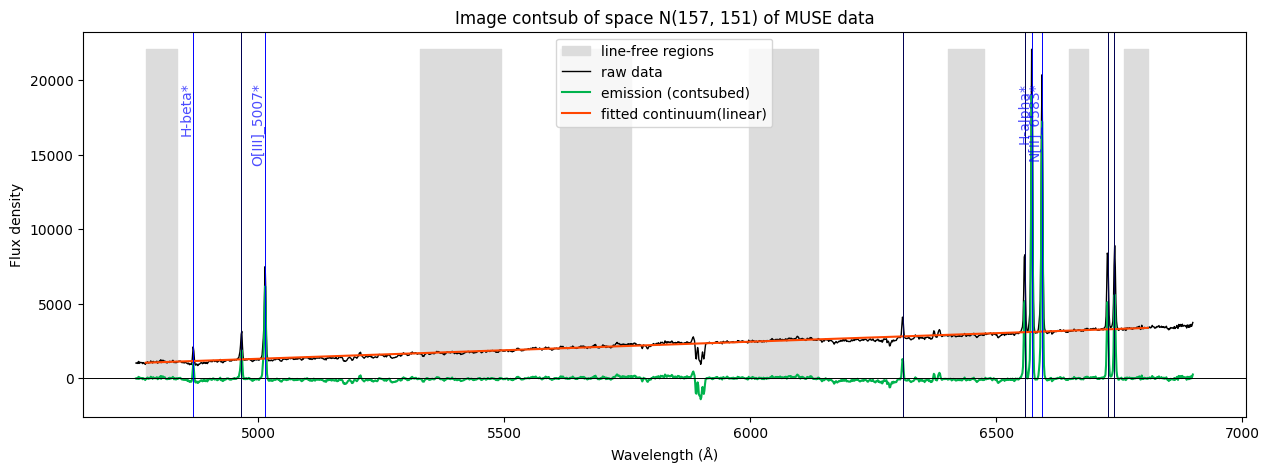

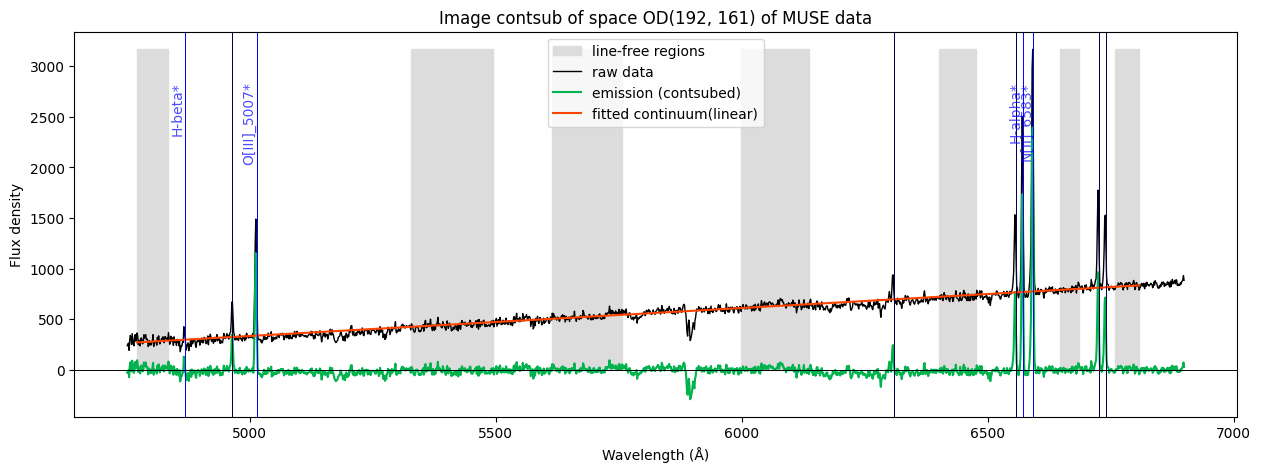

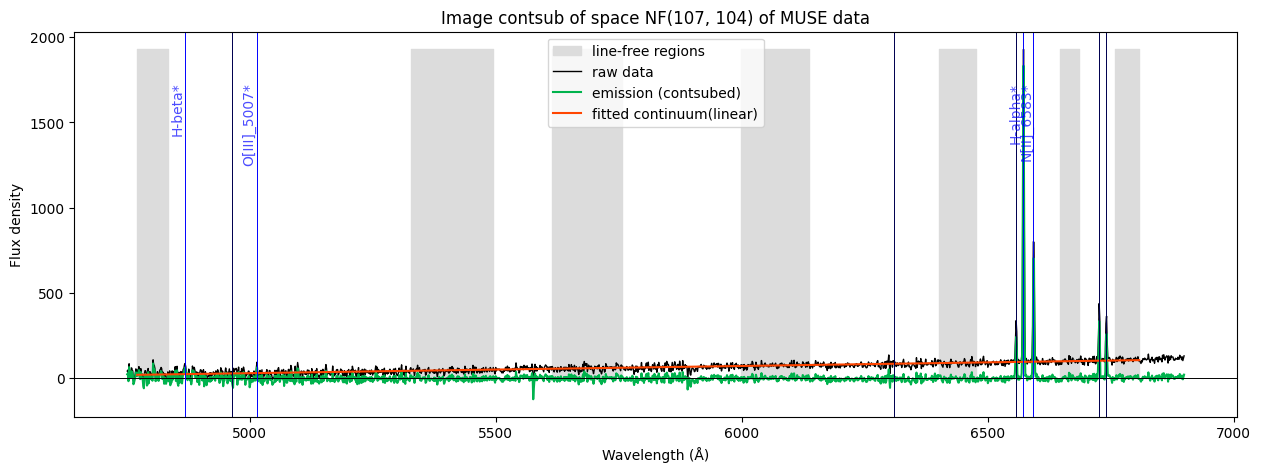

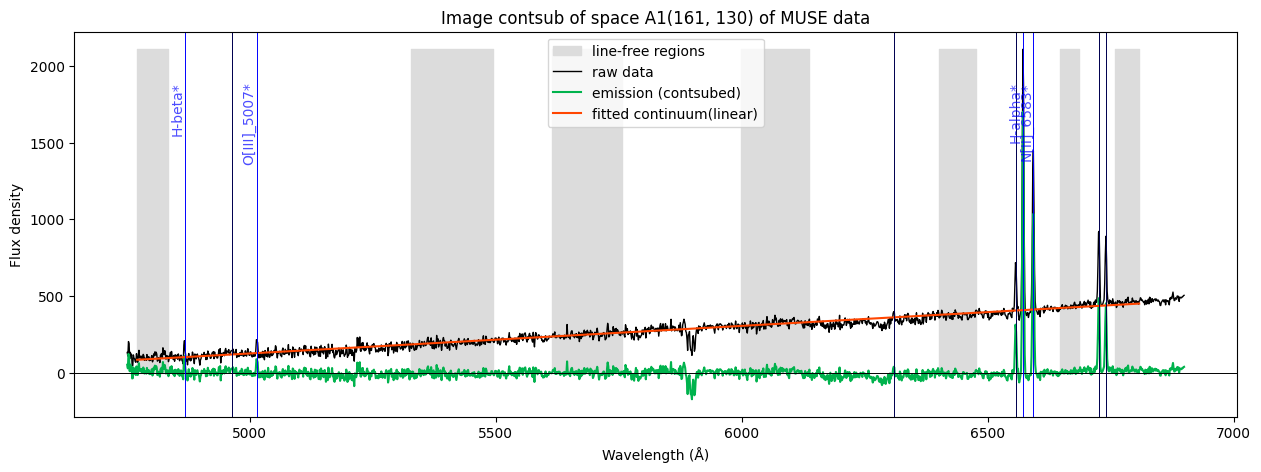

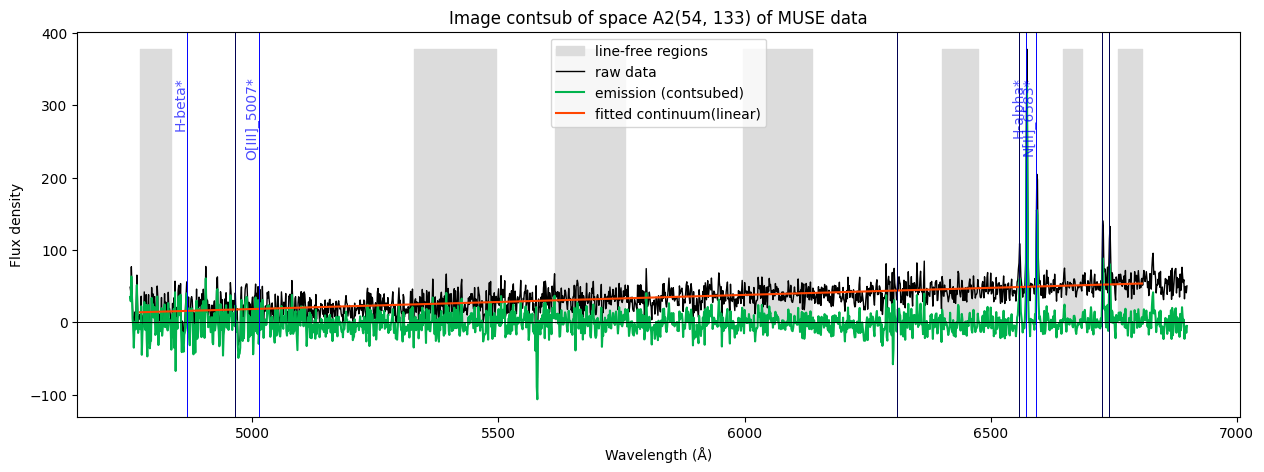

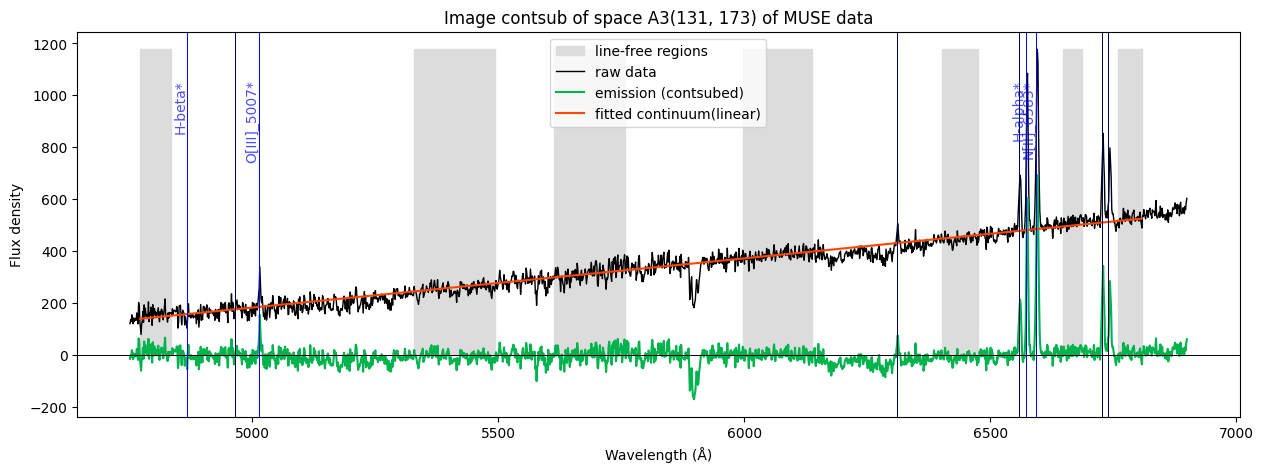

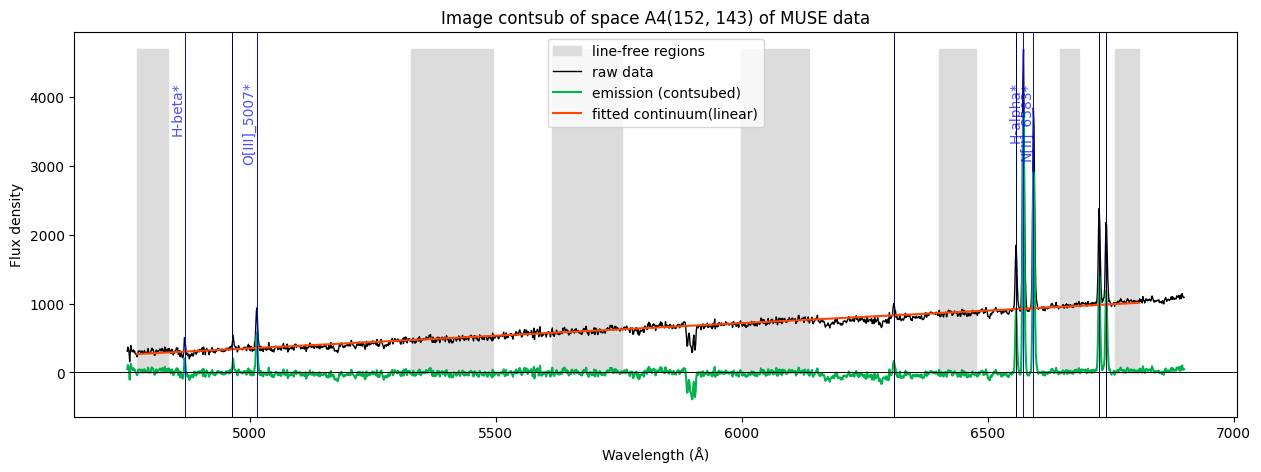

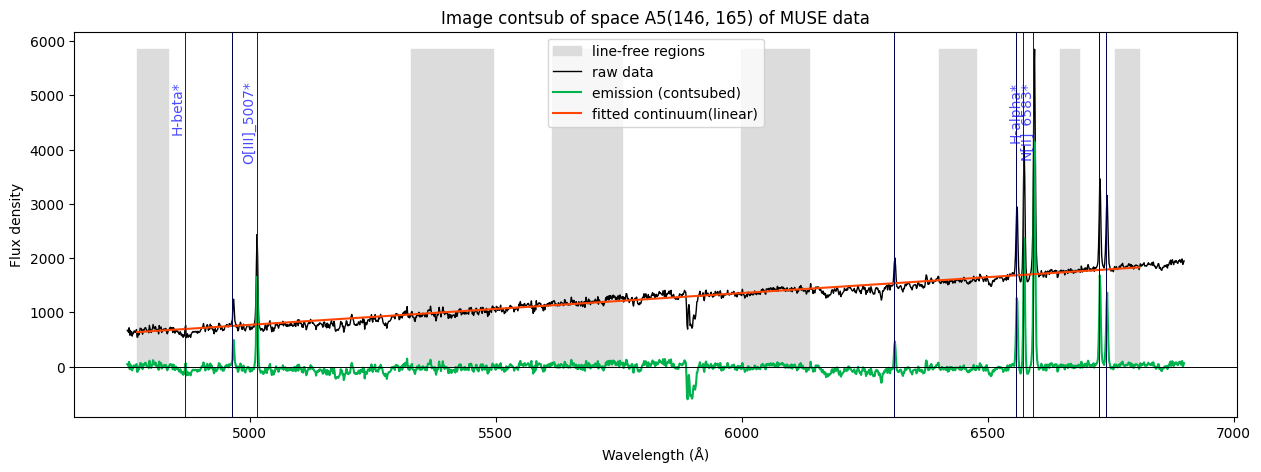

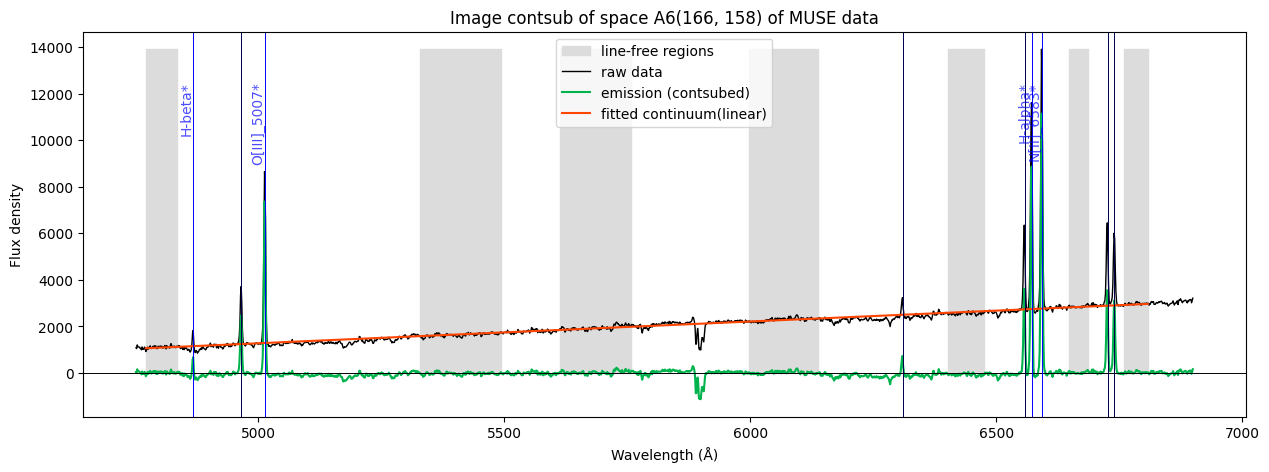

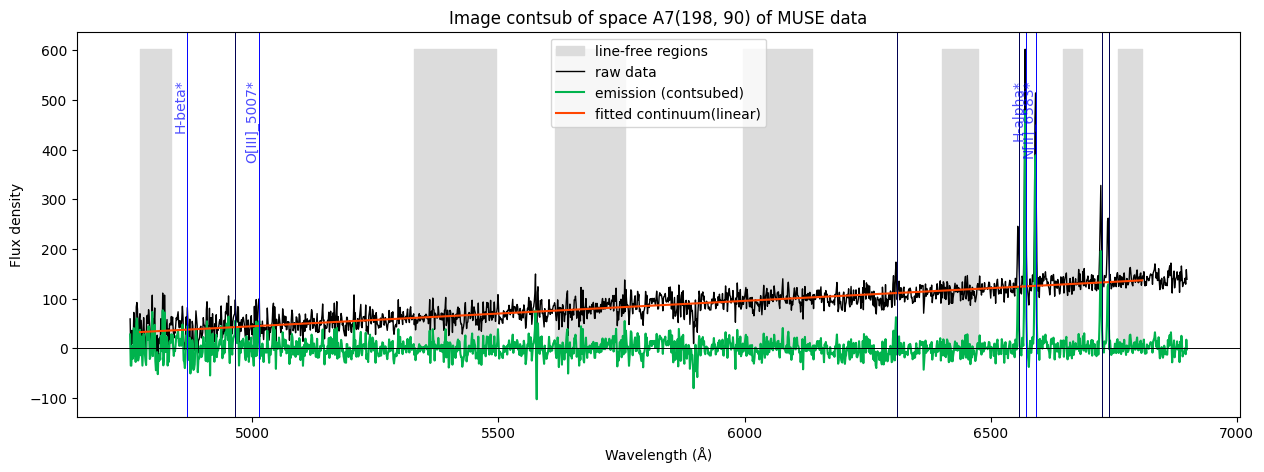

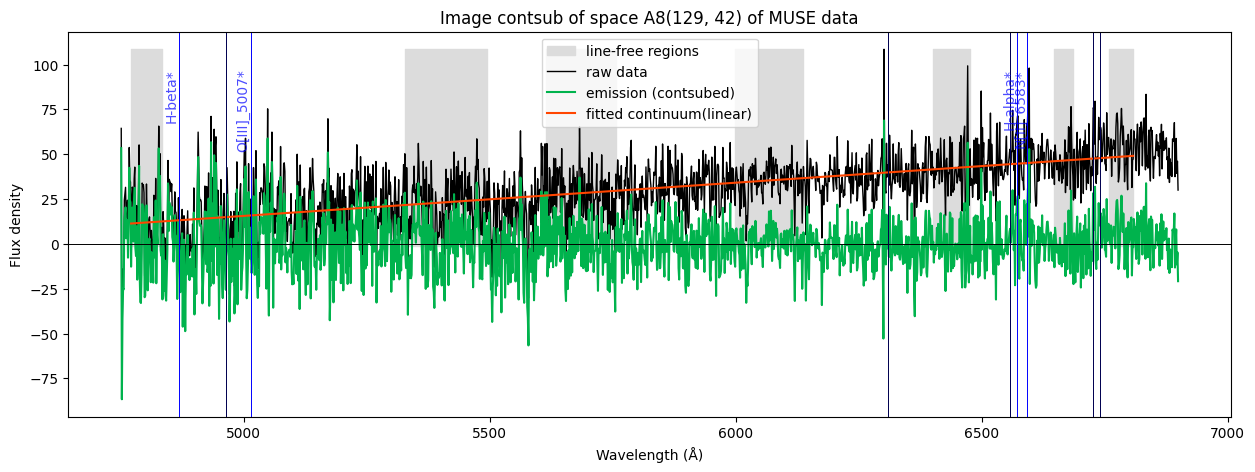

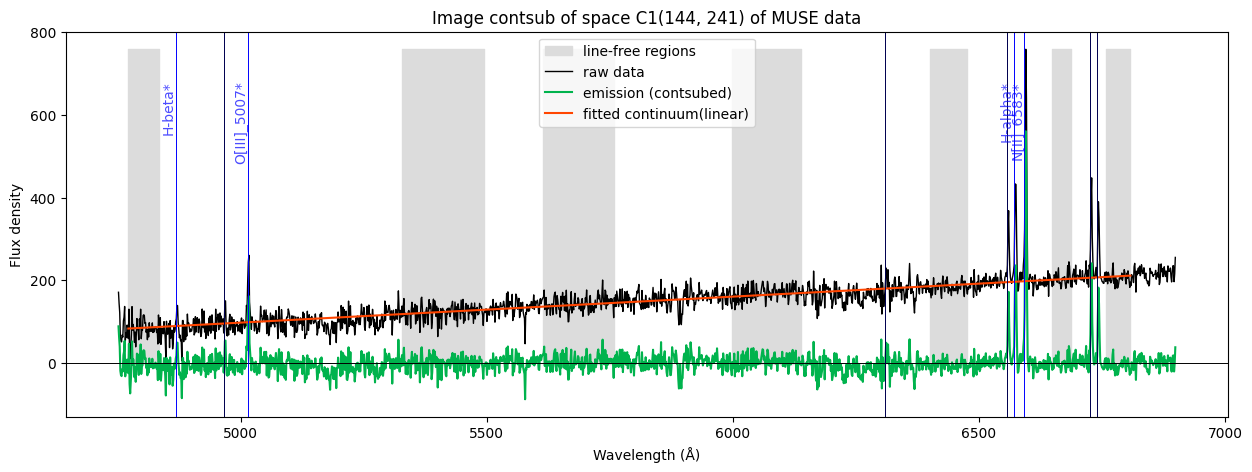

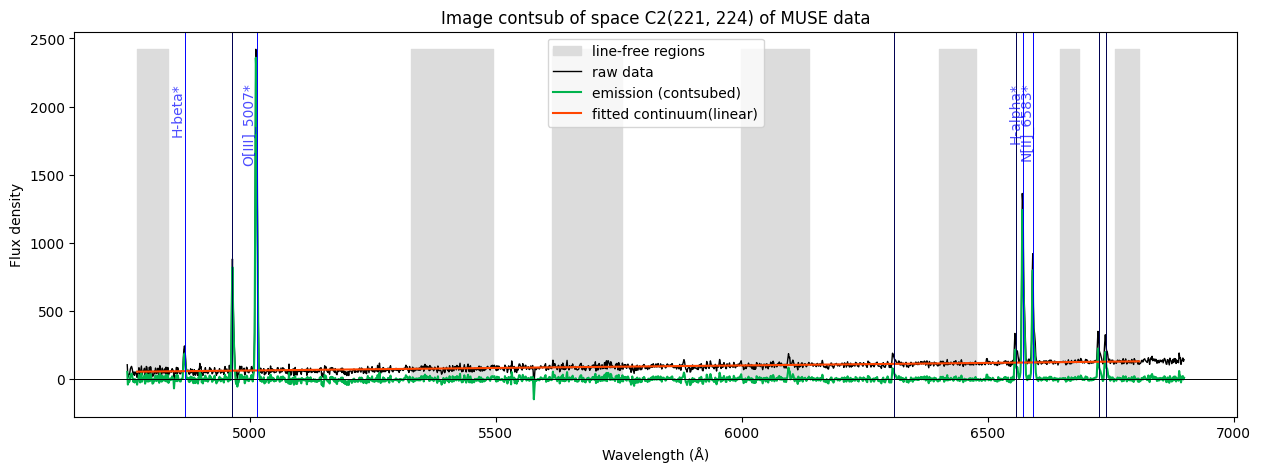

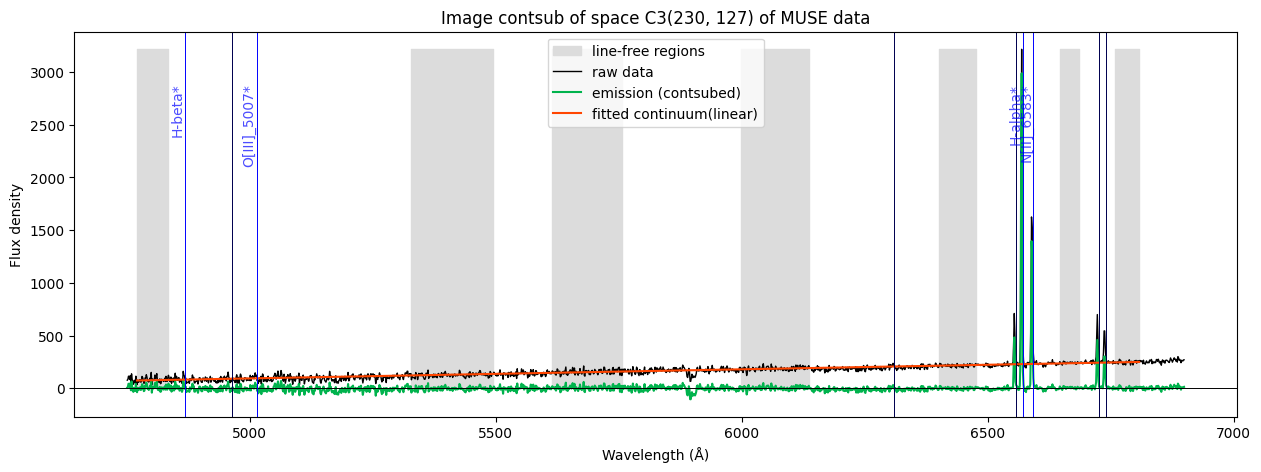

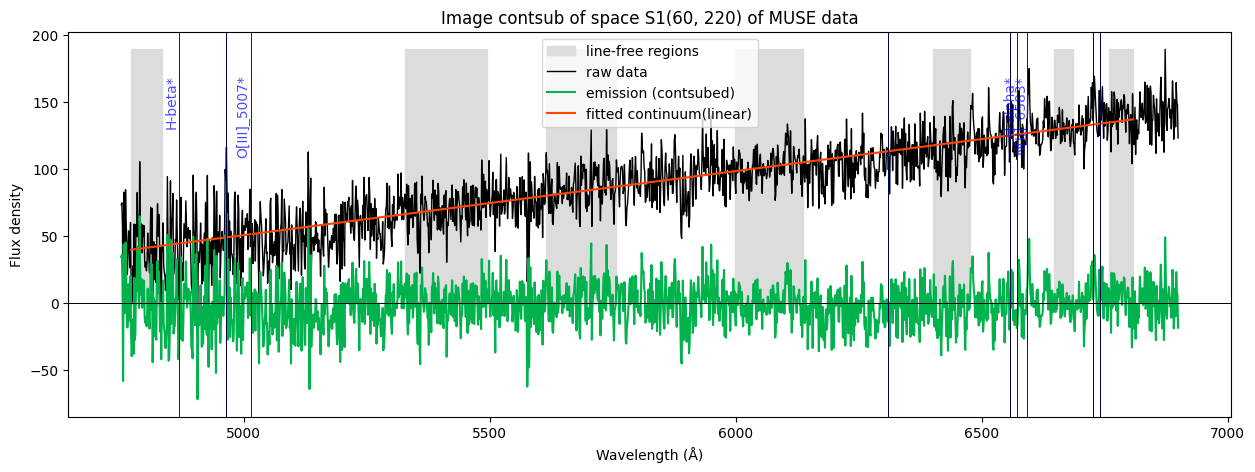

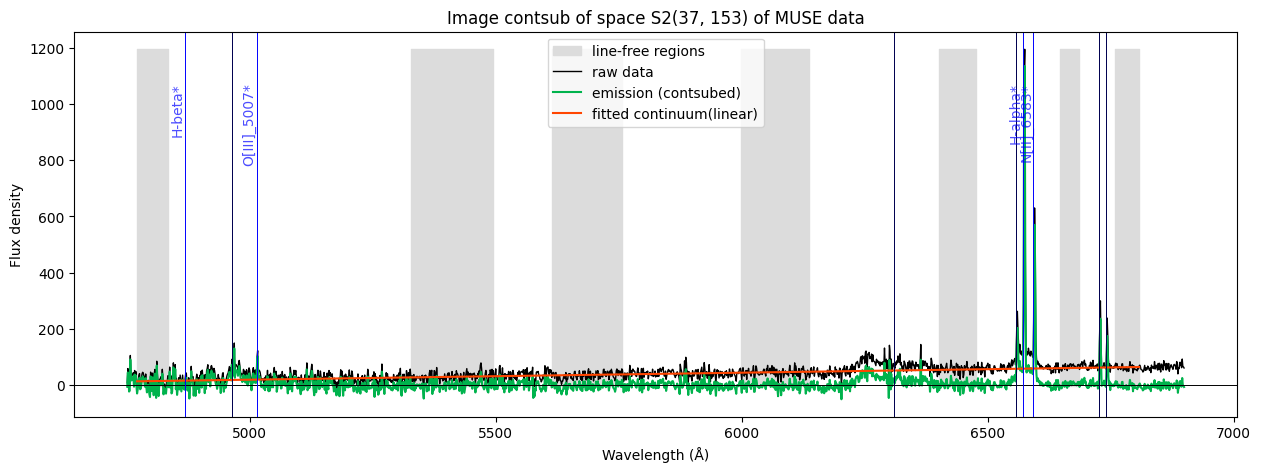

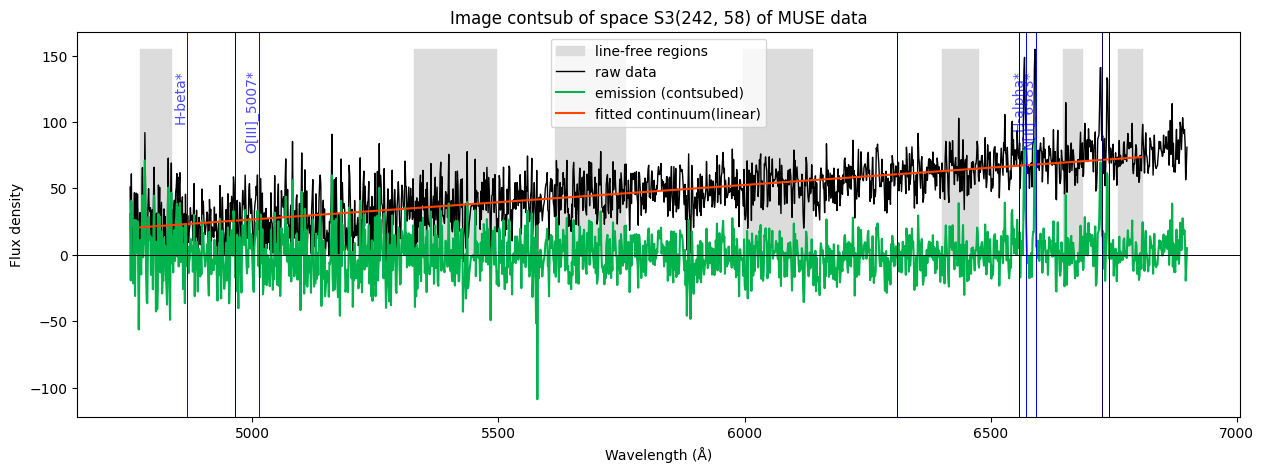

In [285]:
# 畫個
#for i, k in pixel_sample:
for i in range(len(contiL)):
    plt.figure(figsize=(15, 5))
    plt.fill_between(lamb, -1, np.max(fluxL[i]), where=lineFree_channs, # 灰色格子是這樣做的
                    color='gainsboro', label="line-free regions")
    plt.plot(lamb, fluxL[i], c='k', lw=1, label='raw data')
    plt.plot(lamb, emiiL[i], c=(0, 0.7, 0.3), label='emission (contsubed)')
    plt.plot(fitting_lamb, contiL[i], c='orangered', label="fitted continuum(linear)")

    plt.axhline(0, c='k', lw=0.7)
    plt.xlabel("Wavelength (Å)")
    plt.ylabel("Flux density")
    plt.title(f'Image contsub of space {pixel_sample[i][0]}({pixel_sample[i][1]}, {pixel_sample[i][2]}) of MUSE data')
    Plot_emission(np.max(fluxL[i]))

    plt.legend(loc='upper center')
    plt.show()
